In [45]:
!pip install thefuzz
!pip install python-Levenshtein

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from thefuzz import fuzz
from thefuzz import process
import os
import glob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 2.3 MB/s eta 0:00:00


In [46]:
from google.colab import drive
drive.mount('/content/drive')
PATH_COMPLETO = '/content/drive/MyDrive/shein/us-shein-bags_and_luggage-4299.csv'

try:
    df = pd.read_csv(PATH_COMPLETO)
    df_original = df.copy()
    print(f"Dataset carregado com sucesso. Tamanho: {len(df_original)} registros.")

except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado: {PATH_COMPLETO}")
    exit()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset carregado com sucesso. Tamanho: 4298 registros.



--- EXPLORAÇÃO: ANTES DA LIMPEZA ---
Registros: 4298
Duplicatas: 31

Valores ausentes (Top 5):
goods-title-link--jump         4259
goods-title-link--jump href    4259
rank-sub                       3893
rank-title                     3893
color-count                    2506
dtype: int64


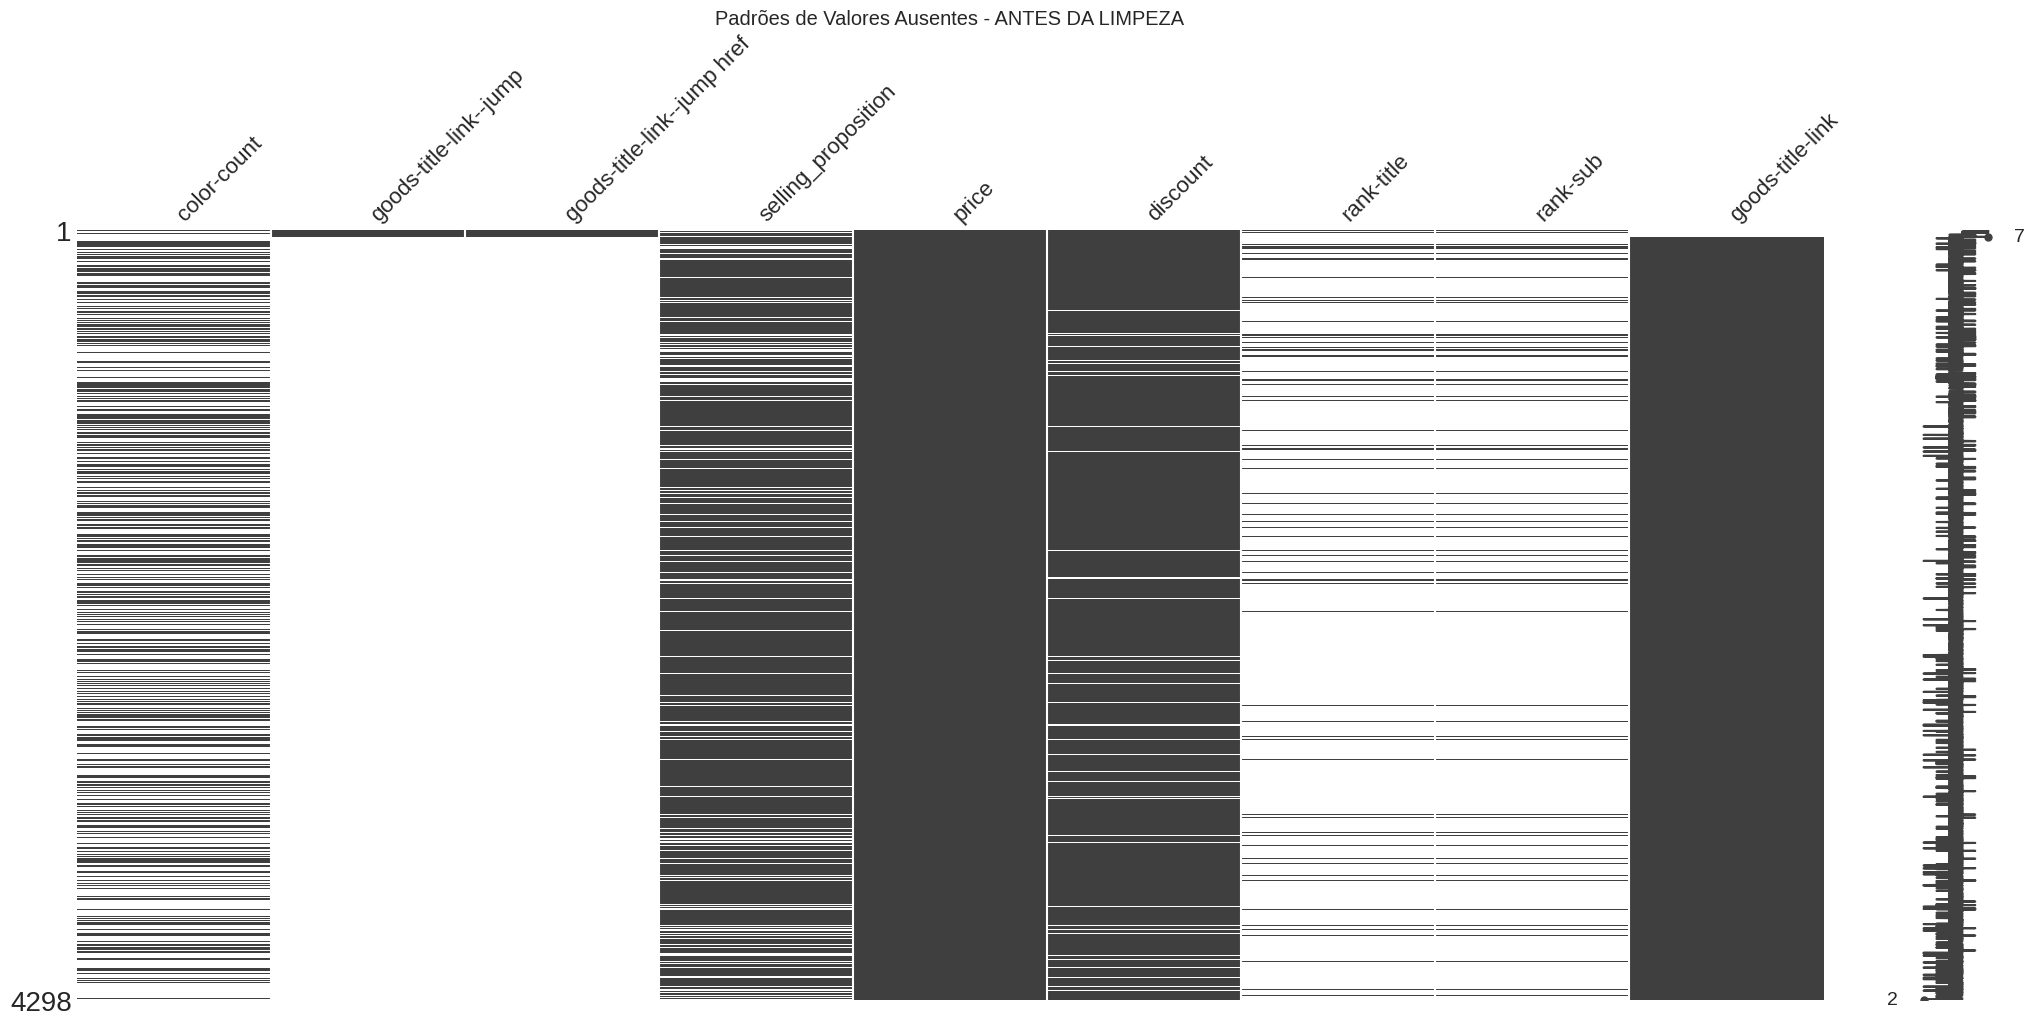


[1/5] Remoção de Duplicatas: 31 removidas.
[2/5] Tratamento de Valores Ausentes concluído.
[3/5] Padronização de Texto e Feature Engineering concluídos.

--- EXPLORAÇÃO: DEPOIS DA LIMPEZA ---
Registros: 4267
Duplicatas: 0

Valores ausentes (Top 5):
goods-title-link--jump href    4228
rank-sub                       3862
discount                        144
discount_rate                   144
color-count                       0
dtype: int64


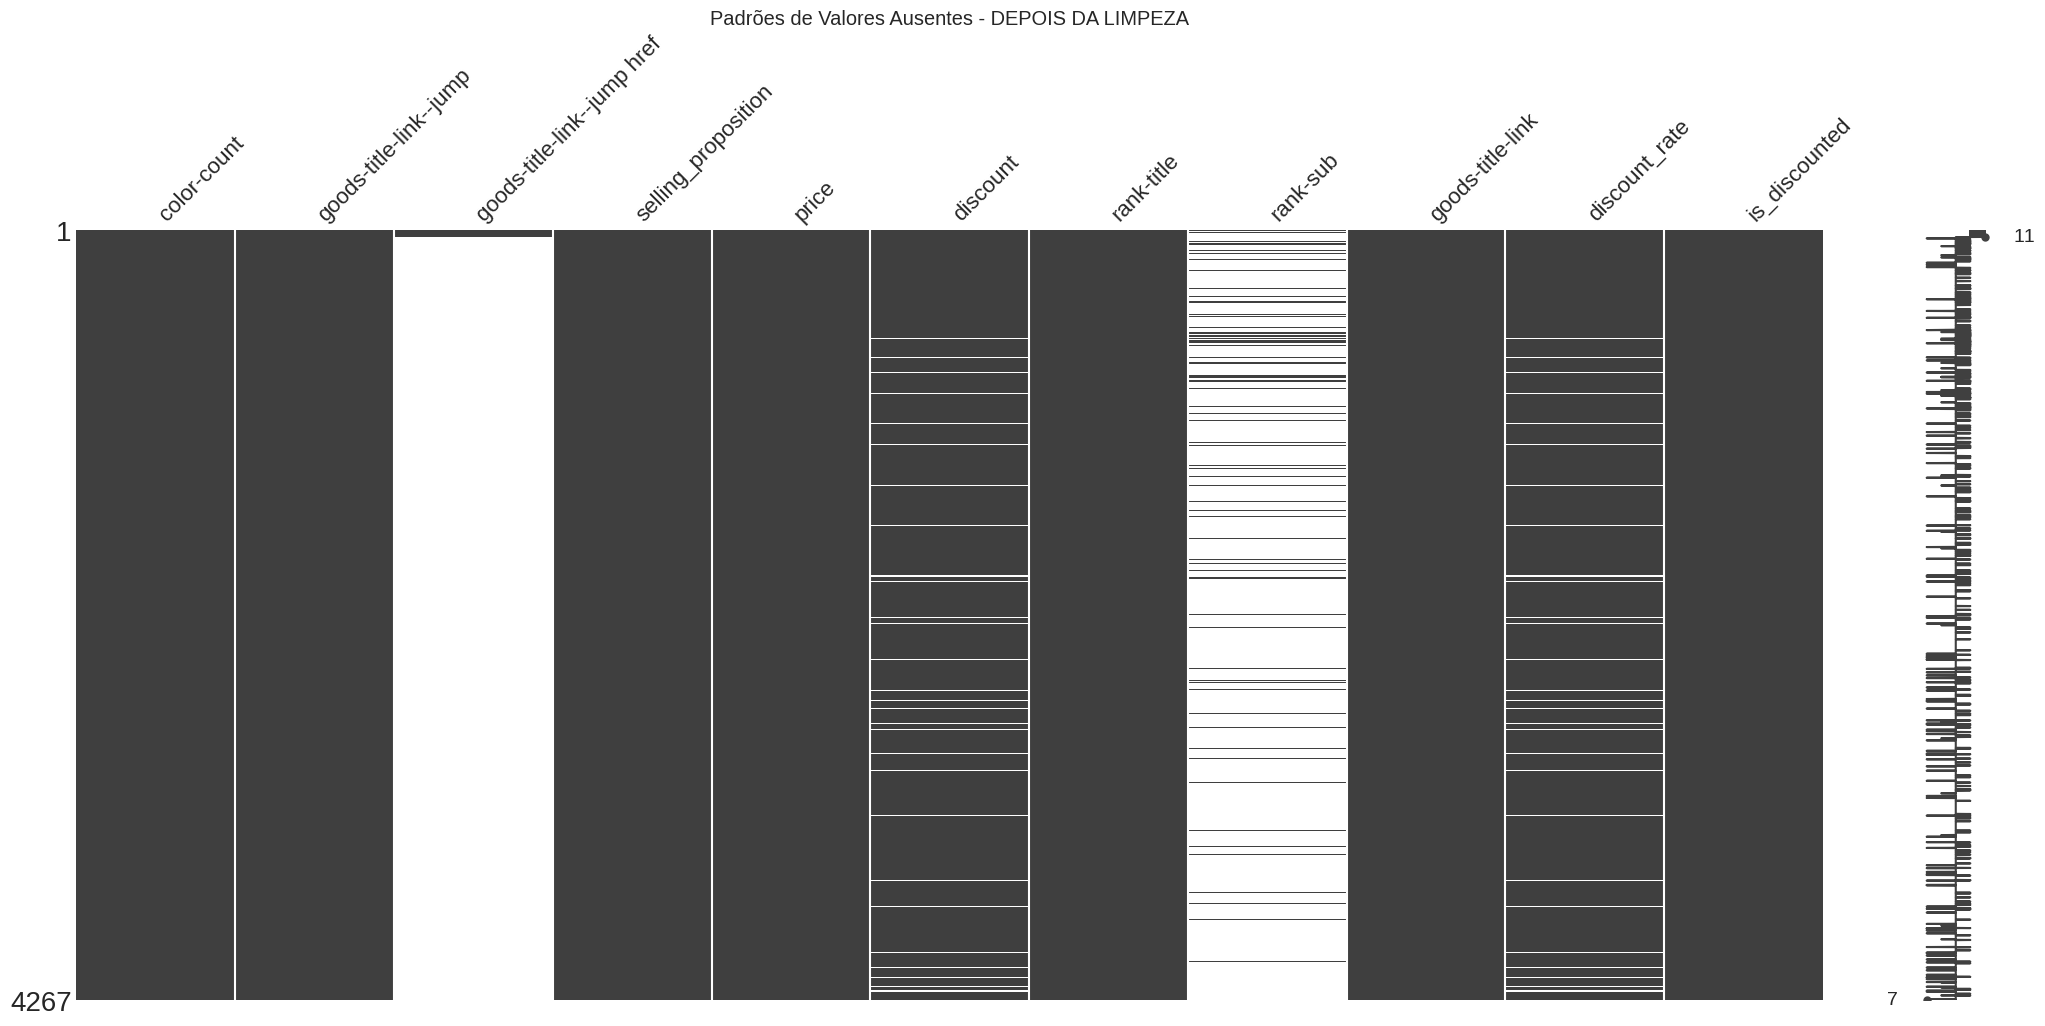

RELATÓRIO FINAL: IMPACTO DA LIMPEZA


In [47]:
# 21. Exploração inicial dos dados (Função adaptada)
def explore_data(df, title):
    print(f"\n--- EXPLORAÇÃO: {title} ---")
    print(f"Registros: {len(df)}")
    print(f"Duplicatas: {df.duplicated().sum()}")
    print("\nValores ausentes (Top 5):")
    print(df.isnull().sum().sort_values(ascending=False).head())

    # Visualizar padrões de valores ausentes
    msno.matrix(df)
    plt.title(f'Padrões de Valores Ausentes - {title}')
    plt.show()

# Executar exploração inicial (Antes da Limpeza)
explore_data(df, "ANTES DA LIMPEZA")


def complete_cleaning_pipeline(df):
    """Implementa o pipeline completo de limpeza de dados."""
    df_clean = df.copy()

    # 21.1 TRATAMENTO DE DUPLICATAS EXATAS
    initial_duplicates = df_clean.duplicated().sum()
    df_clean.drop_duplicates(inplace=True)
    print(f"\n[1/5] Remoção de Duplicatas: {initial_duplicates} removidas.")

    # 21.2 TRATAMENTO DE VALORES AUSENTES (Imputação por moda/mediana)
    # Exemplo: 'color-count' é categórica/discreta, 'price' é numérica.

    # Imputação Categórica (Moda)
    for col in ['color-count', 'selling_proposition', 'rank-title']:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode().iloc[0]
            df_clean[col].fillna(mode_val, inplace=True)

    # Imputação Numérica (Mediana)
    if 'price' in df_clean.columns and df_clean['price'].isnull().any():
        # Antes da imputação numérica, tratamos a coluna 'price' para extrair números
        df_clean['price'] = df_clean['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
        df_clean['price_numeric'] = pd.to_numeric(df_clean['price'], errors='coerce')
        median_price = df_clean['price_numeric'].median()
        df_clean['price_numeric'].fillna(median_price, inplace=True)

    print("[2/5] Tratamento de Valores Ausentes concluído.")

    # 21.3 PADRONIZAÇÃO DE FORMATOS DE TEXTO E CRIAÇÃO DE FEATURES

    # Padronização de Texto (Exemplo simples: títulos para minúsculas)
    text_cols = ['goods-title-link', 'goods-title-link--jump']
    for col in text_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.lower().str.strip()

    # Feature Engineering (Extrair taxa de desconto)
    if 'discount' in df_clean.columns:
        df_clean['discount_rate'] = df_clean['discount'].astype(str).str.replace('%', '', regex=False).str.replace('-', '', regex=False)
        df_clean['discount_rate'] = pd.to_numeric(df_clean['discount_rate'], errors='coerce') / 100
        df_clean['is_discounted'] = np.where(df_clean['discount_rate'] > 0, 1, 0)

    print("[3/5] Padronização de Texto e Feature Engineering concluídos.")

    # 21.4 DETECÇÃO E TRATAMENTO DE OUTLIERS (Capping)

    # Usaremos a coluna numérica recém-criada 'price_numeric'
    if 'price_numeric' in df_clean.columns:
        Q1 = df_clean['price_numeric'].quantile(0.25)
        Q3 = df_clean['price_numeric'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping: Substituir outliers pelos limites do IQR
        df_clean['price_numeric'] = np.where(df_clean['price_numeric'] > upper_bound, upper_bound, df_clean['price_numeric'])
        df_clean['price_numeric'] = np.where(df_clean['price_numeric'] < lower_bound, lower_bound, df_clean['price_numeric'])

        print("[4/5] Tratamento de Outliers (Capping) em 'price_numeric' concluído.")

    # 21.5 PADRONIZAÇÃO DE DADOS (StandardScaler)
    # Aplicar Padronização na feature tratada
    if 'price_numeric' in df_clean.columns:
        scaler = StandardScaler()
        # Reshape necessário para o StandardScaler
        df_clean['price_standardized'] = scaler.fit_transform(df_clean[['price_numeric']])
        print("[5/5] Padronização (StandardScaler) aplicada à coluna 'price_numeric'.")

    return df_clean

# Executar o pipeline de limpeza
df_clean = complete_cleaning_pipeline(df)

# 23. Avaliação da qualidade dos dados depois da limpeza
explore_data(df_clean, "DEPOIS DA LIMPEZA")


# Preparar um relatório final
print("RELATÓRIO FINAL: IMPACTO DA LIMPEZA")

# Comparar estatísticas descritivas
if 'price_numeric' in df_clean.columns:

    print("\nEstatísticas da Coluna de Preço (Antes vs. Depois):")
    stats_comparison = pd.DataFrame({
        'Original': df_original['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float).describe(),
        'Limpo (Capping)': df_clean['price_numeric'].describe()
    })
    print(stats_comparison)

    # Visualização do impacto do Capping
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_original['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float))
    plt.title('Preço Original (Com Outliers)')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean['price_numeric'])
    plt.title('Preço Limpo (Após Capping)')

    plt.tight_layout()
    plt.show()